In [1]:
%matplotlib inline
import os
import sys
import random
sys.path.append('../midi')

import torch #load pytorch
import torch.nn as nn #Load neural network from pytorch
from torch.autograd import Variable
import torch.utils.data as data

In [2]:
from midi_utils import midiread, midiwrite #For reading and writing midi files
from matplotlib import pyplot as plt #For displaying graphs
import skimage.io as io
from IPython.display import FileLink
os.environ["CUDA_VISIBLE_DEVICES"] = '0' #For using graphics

# DataLoader

In [4]:
import numpy as np
import torch
import torch.utils.data as data


def midi_filename_to_piano_roll(midi_filename): #Function to get piano roll from a given midi file name
    
    midi_data = midiread(midi_filename, dt=0.3) #Read midi file using midiread function(imported from midi_utils)
    
    piano_roll = midi_data.piano_roll.transpose() #Obtain piano roll from midi data, All 88 key values will be in the range of 0 and 1
    
    piano_roll[piano_roll > 0] = 1 # Pressed notes are replaced by 1
    
    return piano_roll


def pad_piano_roll(piano_roll, max_length=132333, pad_value=0): #If all piano rolls are not of same length, pad some 0 at the end
        
    original_piano_roll_length = piano_roll.shape[1]
    
    padded_piano_roll = np.zeros((88, max_length))
    padded_piano_roll[:] = pad_value
    
    padded_piano_roll[:, -original_piano_roll_length:] = piano_roll

    return padded_piano_roll


class NotesGenerationDataset(data.Dataset): #Make a proper dataset for training
    
    def __init__(self, midi_folder_path, longest_sequence_length=1491): #Read all midi files in the midi_folder_path
        
        self.midi_folder_path = midi_folder_path
        
        midi_filenames = os.listdir(midi_folder_path)
        
        self.longest_sequence_length = longest_sequence_length
        
        midi_full_filenames = map(lambda filename: os.path.join(midi_folder_path, filename),midi_filenames)
        
        self.midi_full_filenames = list(midi_full_filenames)
        
        if longest_sequence_length is None:
            
            self.update_the_max_length()
    
    
    def update_the_max_length(self):#If the max_length is not mentioned, Update it by the longest sequence in the available data
        
        sequences_lengths = map(lambda filename: midi_filename_to_piano_roll(filename).shape[1],self.midi_full_filenames)
        
        max_length = max(sequences_lengths)
        
        self.longest_sequence_length = max_length
                
    
    def __len__(self): #Return number of midi files in the given path
        
        return len(self.midi_full_filenames)
    
    def __getitem__(self, index): #Used to obtain midi files one by one for training
        
        midi_full_filename = self.midi_full_filenames[index]
        
        piano_roll = midi_filename_to_piano_roll(midi_full_filename)
        
        # Shifting by one time step
        sequence_length = piano_roll.shape[1] - 1
        
        # Shifting by one time step
        input_sequence = piano_roll[:, :-1]
        ground_truth_sequence = piano_roll[:, 1:]
                
        # padding sequence so that all of them have the same length
        input_sequence_padded = pad_piano_roll(input_sequence, max_length=self.longest_sequence_length)
        
        ground_truth_sequence_padded = pad_piano_roll(ground_truth_sequence,max_length=self.longest_sequence_length,pad_value=-100)
                
        input_sequence_padded = input_sequence_padded.transpose()
        ground_truth_sequence_padded = ground_truth_sequence_padded.transpose()
        
        return (torch.FloatTensor(input_sequence_padded),torch.LongTensor(ground_truth_sequence_padded),torch.LongTensor([sequence_length]) )

    
def post_process_sequence_batch(batch_tuple):#Consider one half of midi data as input and later part as output
    
    input_sequences, output_sequences, lengths = batch_tuple
    
    splitted_input_sequence_batch = input_sequences.split(split_size=1)
    splitted_output_sequence_batch = output_sequences.split(split_size=1)
    splitted_lengths_batch = lengths.split(split_size=1)

    training_data_tuples = zip(splitted_input_sequence_batch,
                               splitted_output_sequence_batch,
                               splitted_lengths_batch)

    training_data_tuples_sorted = sorted(training_data_tuples,
                                         key=lambda p: int(p[2]),
                                         reverse=True)

    splitted_input_sequence_batch, splitted_output_sequence_batch, splitted_lengths_batch = zip(*training_data_tuples_sorted)

    input_sequence_batch_sorted = torch.cat(splitted_input_sequence_batch)
    output_sequence_batch_sorted = torch.cat(splitted_output_sequence_batch)
    lengths_batch_sorted = torch.cat(splitted_lengths_batch)
    
    input_sequence_batch_sorted = input_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    output_sequence_batch_sorted = output_sequence_batch_sorted[:, -lengths_batch_sorted[0, 0]:, :]
    
    input_sequence_batch_transposed = input_sequence_batch_sorted.transpose(0, 1)
    
    lengths_batch_sorted_list = list(lengths_batch_sorted)
    lengths_batch_sorted_list = map(lambda x: int(x), lengths_batch_sorted_list)
    
    return input_sequence_batch_transposed, output_sequence_batch_sorted, list(lengths_batch_sorted_list)

In [5]:
trainset = NotesGenerationDataset('./Nottingham/train/', longest_sequence_length=None) #Load and process training data

trainset_loader = data.DataLoader(trainset, batch_size=8,shuffle=True, drop_last=True) #Pytorch expects inputs in the DataLoader form

In [6]:
X = next(iter(trainset_loader)) #Since we need to able to iterate through the dataset, make it iterable
print(X[0][0])
X[0].shape

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


torch.Size([8, 1491, 88])

In [7]:
valset = NotesGenerationDataset('./Nottingham/valid/', longest_sequence_length=None) #Read and process validation data
valset_loader = data.DataLoader(valset, batch_size=8, shuffle=False, drop_last=False)
X_val = next(iter(valset_loader))
X_val[0].shape

torch.Size([8, 1229, 88])

In [8]:
#https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7 
#Refer the above mentioned site for understanding train-validate-test split of data

# RNN

In [9]:
#Write a RNN model with LSTM cells in it
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_classes, n_layers=2): #Initialize Network
        #Here input will be 88 because we have 88 keay in a piano
        super(RNN, self).__init__()
        #Initialze the model parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.n_layers = n_layers
        
        #Add linear layer with inputs and hidden_size number of out_features
        self.notes_encoder = nn.Linear(in_features=input_size, out_features=hidden_size)
        #Since output of linear layer will be varying over large range(eg:0-100,0-10 etc), Convert it into of range between 0 and 1 by using batch normalisation
        self.bn = nn.BatchNorm1d(hidden_size)
        #Add LSTM layers to the network
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        #Add output linear layer, Here num_classes=88 because we will be generating the value corresponding to either of the 88 keys in the piano
        self.logits_fc = nn.Linear(hidden_size, num_classes)
    
    
    def forward(self, input_sequences, input_sequences_lengths, hidden=None):
        #This part is used to pass each midi sequence through the above mentioned neural network architecture
        #At each step, the output of previous layer  is given as input to the next layer
        batch_size = input_sequences.shape[1]

        notes_encoded = self.notes_encoder(input_sequences)
        
        notes_encoded_rolled = notes_encoded.permute(1,2,0).contiguous()
        notes_encoded_norm = self.bn(notes_encoded_rolled)
        
        notes_encoded_norm_drop = nn.Dropout(0.25)(notes_encoded_norm)
        notes_encoded_complete = notes_encoded_norm_drop.permute(2,0,1)
        
        # Here we run rnns only on non-padded regions of the batch
        packed = torch.nn.utils.rnn.pack_padded_sequence(notes_encoded_complete, input_sequences_lengths)
        outputs, hidden = self.lstm(packed, hidden)
        
        # Here we unpack sequence(back to padded)
        outputs, output_lengths = torch.nn.utils.rnn.pad_packed_sequence(outputs)
        
        outputs_norm = self.bn(outputs.permute(1,2,0).contiguous())
        outputs_drop = nn.Dropout(0.1)(outputs_norm)
        logits = self.logits_fc(outputs_drop.permute(2,0,1))
        logits = logits.transpose(0, 1).contiguous()
        
        neg_logits = (1 - logits)
        
        # Since the BCE loss doesn't support masking,crossentropy is used
        binary_logits = torch.stack((logits, neg_logits), dim=3).contiguous()
        logits_flatten = binary_logits.view(-1, 2)
        return logits_flatten, hidden

In [10]:
#Instantiate RNN model
#input_size and num_classes are 88 because we are predicting either of the 88 piano key values from the 88 input key sequence
model = RNN(input_size=88, hidden_size=512, num_classes=88).cuda()

criterion = nn.CrossEntropyLoss().cuda() #Use CrossEntropyLoss
criterion_val = nn.CrossEntropyLoss().cuda()

AssertionError: 
Found no NVIDIA driver on your system. Please check that you
have an NVIDIA GPU and installed a driver from
http://www.nvidia.com/Download/index.aspx

In [13]:
def validate(model): #Function for validation process where the model is tested for accuracy after every batch of midi data is trained to the network
    model.eval()
    full_val_loss = 0.0
    overall_sequence_length = 0.0

    for batch in valset_loader:

        post_processed_batch_tuple = post_process_sequence_batch(batch)

        input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

        output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

        input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

        logits, _ = model(input_sequences_batch_var, sequences_lengths)

        loss = criterion_val(logits, output_sequences_batch_var)

        full_val_loss += loss.item()
        overall_sequence_length += sum(sequences_lengths)

    return full_val_loss / (overall_sequence_length * 88)

In [15]:
clip = 1.0
epochs_number = 10 #Number of iterations though the training dataset
sample_history = []
best_val_loss = float("inf")

In [16]:
#Finding learning rate by training model for 2 iterations(epochs) through the dataset and checking for least loss
#Plot graph of learning rate vs loss
def lrfinder(start, end, model, trainset_loader, epochs=2):
    model.train() # into training mode
    lrs = np.linspace(start, end, epochs*len(trainset_loader))
    parameters = filter(lambda p: p.requires_grad, model.parameters()) # get all parameters which need grad
    optimizer = torch.optim.Adam(rnn.parameters(),start)
    loss_list = []
    ctr = 0
    
    for epoch_number in range(epochs):
        epoch_loss = []
        for batch in trainset_loader:
            optimizer.param_groups[0]['lr'] = lrs[ctr]
            ctr = ctr+1

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(rnn.parameters(), clip)

            optimizer.step()
        print('Epoch %d' % epoch_number)
    plt.title('Learning rate vs Loss curve')
    plt.plot(lrs, loss_list)
    return lrs, loss_list

Epoch 0
Epoch 1


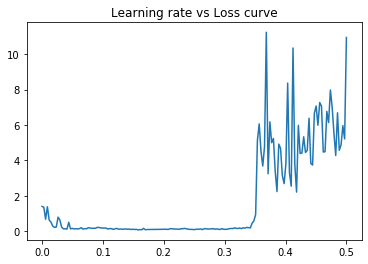

In [17]:
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()
lrs, losses = lrfinder(1e-4, 1e-1*5, rnn, trainset_loader)
#Find learning rate by training for 2 epochs

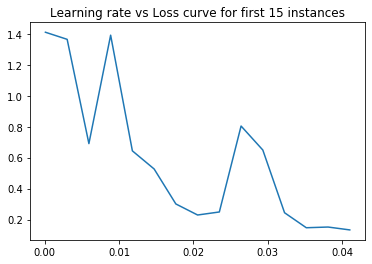

In [18]:
plt.title('Learning rate vs Loss curve for first 15 instances')
plt.plot(lrs[:15], losses[:15])

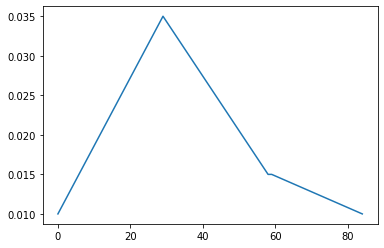

In [19]:
#Split the above curve into multiple batches
#From the batches find out the learning rate which gives least loss
def get_triangular_lr(lr_low, lr_high, mini_batches):
    iterations = mini_batches
    lr_mid = lr_high/7 + lr_low
    up = np.linspace(lr_low, lr_high, int(round(iterations*0.35)))
    down = np.linspace(lr_high, lr_mid, int(round(iterations*0.35)))
    floor = np.linspace(lr_mid, lr_low, int(round(iterations*0.30)))
    return np.hstack([up, down[1:], floor])

lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
plt.plot(lrs_triangular)

In [20]:
clip = 1.0

In [21]:
def train_model(model, lrs_triangular, epochs_number=2, wd=0.0, best_val_loss=float("inf")):
    #Function fro traing the model
    loss_list = []
    val_list =[]
    optimizer = torch.optim.Adam(rnn.parameters(), lr=lrs_triangular[0], weight_decay=wd)
    #Use Adam optimizer refer-https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/ for basic understanding
    for epoch_number in range(epochs_number):
        model.train()
        epoch_loss = []
        #Considering each batch from the trainset ,pass it through the network
        #Validate the model at the end of each batch training
        for lr, batch in zip(lrs_triangular, trainset_loader):
            optimizer.param_groups[0]['lr'] = lr

            post_processed_batch_tuple = post_process_sequence_batch(batch)

            input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

            output_sequences_batch_var =  Variable( output_sequences_batch.contiguous().view(-1).cuda() )

            input_sequences_batch_var = Variable( input_sequences_batch.cuda() )

            optimizer.zero_grad()

            logits, _ = model(input_sequences_batch_var, sequences_lengths)

            loss = criterion(logits, output_sequences_batch_var)
            loss_list.append(loss.item())
            epoch_loss.append(loss.item())
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()

        current_trn_epoch = sum(epoch_loss)/len(trainset_loader)
        print('Training Loss: Epoch:',epoch_number,':', current_trn_epoch)

        current_val_loss = validate(model)
        print('Validation Loss: Epoch:',epoch_number,':', current_val_loss)
        print('')

        val_list.append(current_val_loss)
        
        #After complete training save edge weights as a model for future predictions
        if current_val_loss < best_val_loss:

            torch.save(model.state_dict(), 'music_model_padfront_regularized.pth')
            best_val_loss = current_val_loss
    return best_val_loss

In [22]:
#Trainig model
rnn = RNN(input_size=88, hidden_size=512, num_classes=88)
rnn = rnn.cuda()

In [26]:
#Training the model with different learning rate
lrs_triangular = get_triangular_lr(1e-2, 1e-2*3.5, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular)

Training Loss: Epoch: 0 : 0.10449556651157002
Validation Loss: Epoch: 0 : 6.785584826390926e-07

Training Loss: Epoch: 1 : 0.09715645292470622
Validation Loss: Epoch: 1 : 6.782870896515317e-07



In [24]:
#Training the model with different learning rate
lrs_triangular = get_triangular_lr(1e-3, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=2, wd=1e-4, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.09735293634409128
Validation Loss: Epoch: 0 : 6.252943786560418e-07

Training Loss: Epoch: 1 : 0.09755568916714469
Validation Loss: Epoch: 1 : 6.664493074120392e-07



In [27]:
#Training the model with different learning rate

lrs_triangular = get_triangular_lr(1e-4, 1e-2, len(trainset_loader))
best_val_loss = train_model(rnn, lrs_triangular, epochs_number=2, wd=1e-4*5, best_val_loss=best_val_loss)

Training Loss: Epoch: 0 : 0.0963160520376161
Validation Loss: Epoch: 0 : 6.401136616383648e-07

Training Loss: Epoch: 1 : 0.09675079835362213
Validation Loss: Epoch: 1 : 6.448175875583462e-07



In [29]:
#Loading the saved model 
rnn.load_state_dict(torch.load('music_model_padfront_regularized.pth'))
print(rnn)

RNN(
  (notes_encoder): Linear(in_features=88, out_features=512, bias=True)
  (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(512, 512, num_layers=2)
  (logits_fc): Linear(in_features=512, out_features=88, bias=True)
)


In [33]:
#Generating music sequence from a given starting sequence
def sample_from_piano_rnn(rnn, sample_length=4, temperature=1, starting_sequence=None):

    if starting_sequence is None:
                
        current_sequence_input = torch.zeros(1, 1, 88)
        current_sequence_input[0, 0, 40] = 1
        current_sequence_input[0, 0, 50] = 0
        current_sequence_input[0, 0, 56] = 0
        current_sequence_input = Variable(current_sequence_input.cuda())
    else:
        current_sequence_input = starting_sequence
        
    final_output_sequence = [current_sequence_input.data.squeeze(1)]

    hidden = None

    for i in range(sample_length):

        output, hidden = rnn(current_sequence_input, [1], hidden)

        probabilities = nn.functional.softmax(output.div(temperature), dim=1)

        current_sequence_input = torch.multinomial(probabilities.data, 1).squeeze().unsqueeze(0).unsqueeze(1)

        current_sequence_input = Variable(current_sequence_input.float())

        final_output_sequence.append(current_sequence_input.data.squeeze(1))

    sampled_sequence = torch.cat(final_output_sequence, dim=0).cpu().numpy()
    
    return sampled_sequence

In [30]:
#Load test datasets
testset = NotesGenerationDataset('./Nottingham/test/', longest_sequence_length=None)
testset_loader = torch.utils.data.DataLoader(testset, batch_size=1,shuffle=True, drop_last=False)


In [31]:
batch = next(iter(testset_loader))
post_processed_batch_tuple = post_process_sequence_batch(batch)

input_sequences_batch, output_sequences_batch, sequences_lengths = post_processed_batch_tuple

output_sequences_batch_var =  output_sequences_batch.contiguous().view(-1).cuda()

input_sequences_batch_var = input_sequences_batch.cuda()
input_sequences_batch_var.shape

torch.Size([160, 1, 88])

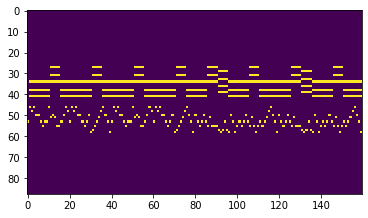

In [32]:
#Displaying one input sequence
#Time vs Key pressed
plt.imshow(input_sequences_batch_var.reshape((input_sequences_batch_var.shape[0],88)).cpu().transpose(0,1))

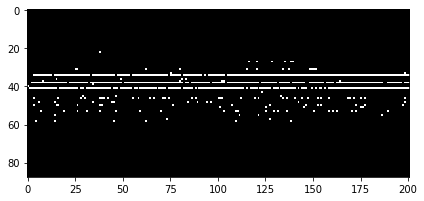

In [35]:
#Predicting music sequence without any starting sequence
#Saving the generated piano sequence as a midi file
sample = sample_from_piano_rnn(rnn, sample_length=200, temperature=0.7,starting_sequence=None).transpose()
io.imshow(sample)
midiwrite('sample_reg_018.mid', sample.transpose(), dt=0.3)